## 技术介绍
### 简介
自动化机器学习就是能够自动建立机器学习模型的方法，其主要包含三个方面：方面一，超参数优化；方面二，自动特征工程与机器学习算法自动选择；方面三，神经网络结构搜索。本文侧重于方面三，神级网络结构搜索。

自动化机器学习的前两个部分，都有一个特点——只对现在已有的算法进行搜索，而不创造新的算法。一般而言机器学习专家在开发机器学习应用或者构建机器学习模型时，都不太可能从头造轮子，直接创造一个新的算法。但是到了深度神经网路的时候，就发生了一些变化。严格意义上来说，神经网络的基本结构都是固定的，有限的。但是每当我们重新创建一个模型的时候，基本单元的不同组合又可以视作是在创建一个新的神经网络模型。在这种基本现实之下，第三种自动化机器学习技术应用而生，那就是神经网络架构搜索综述(NAS)，根据基本的神经网络基本单元创建新的神经网络结构，最终结果就是得到一个非常强大的神经网络。

在这方面也已经有大量的科学家进行了深入的研究。不过由于其基本假设就是深度神经网络，而且是在其之上进行架构的搜索，因此对算力的要求往往都比较高。目前比较厉害，且可以单卡运行的算法当要属enas，而enas的作者在发布论文的同时开源了其基于enas的作品——autokeras，任何人都可以下载和使用该类库。

autokeras底层都是enas算法，但是根据应用不同其存在可以详细的分为以下类型：
 - 图像分类
 - 图像回归
 - 文本分类
 - 文本回归
 - 结构化数据分类
 - 结构化数据回归
我们直接进行比较复杂的操作，使用autokeras进行自动图像分类。

### 技术栈

 - tensorflow
 - pathlib
 - numpy
 - autokeras


## 实现
### 数据
数据我们这里使用的是keras中的flower_photos数据集，该数据集是五类鲜花的图片数据，共有3675张图片。可以直接使用keras自带代下载该数据集。具体命令如下：

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib
import numpy as np
import os

data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("This directory: ",data_dir," have ",image_count,"images")

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("CLASS_NAMES ：",CLASS_NAMES,",They are the names of the secondary directories")

This directory:  /home/fonttian/.keras/datasets/flower_photos  have  3670 images
CLASS_NAMES ： ['roses' 'dandelion' 'daisy' 'sunflowers' 'tulips'] ,They are the names of the secondary directories


### 数据读取

之后我们将数据的读取转化为tfds格式，这样使用效率会高很多，具体实现如下：

In [3]:
import warnings
warnings.filterwarnings("ignore")

print("----------------- 参数 -----------------")

BATCH_SIZE = 256
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

print("----------------- start tfds -----------------")
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print("type(labeled_ds): ",type(labeled_ds))

----------------- 参数 -----------------
----------------- start tfds -----------------
type(labeled_ds):  <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


### 创建模型并训练
之后我们使用几条简单的命令进行模型的创建，然后使用fit方法进行训练。

In [4]:
print("----------------- autokeras.fit with tfds -----------------")

import autokeras as ak
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)

print("type(clf) :",type(clf))

# Feed the tensorflow Dataset to the classifier.
# model = clf.fit(train_ds, epochs=10)
clf.fit(labeled_ds, epochs=10)
print("End of training")

----------------- autokeras.fit with tfds -----------------
type(clf) : <class 'autokeras.tasks.image.ImageClassifier'>


Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 1.6533 - accuracy: 0.18 - ETA: 5s - loss: 3.6870 - accuracy: 0.18 - ETA: 7s - loss: 12.2507 - accuracy: 0.187 - ETA: 8s - loss: 20.0298 - accuracy: 0.179 - ETA: 8s - loss: 19.0134 - accuracy: 0.181 - ETA: 8s - loss: 17.3803 - accuracy: 0.208 - ETA: 8s - loss: 15.9739 - accuracy: 0.218 - ETA: 8s - loss: 15.4824 - accuracy: 0.203 - ETA: 9s - loss: 14.5257 - accuracy: 0.194 - ETA: 9s - loss: 13.4858 - accuracy: 0.200 - ETA: 8s - loss: 12.6732 - accuracy: 0.201 - ETA: 8s - loss: 11.9021 - accuracy: 0.203 - ETA: 8s - loss: 11.1935 - accuracy: 0.204 - ETA: 8s - loss: 10.5573 - accuracy: 0.214 - ETA: 8s - loss: 9.9689 - accuracy: 0.216 - ETA: 8s - loss: 9.4486 - accuracy: 0.21 - ETA: 8s - loss: 8.9894 - accuracy: 0.21 - ETA: 8s - loss: 8.5781 - accuracy: 0.21 - ETA: 8s - loss: 8.2122 - accuracy: 0.21 - ETA: 8s - loss: 7.8813 - accuracy: 0.21 - ETA: 8s - loss: 7.5818 - accuracy: 0.22 - ETA: 7s - loss: 7.3103 - accuracy: 0.22 -

92/92 [==============================] - ETA: 0s - loss: 1.5793 - accuracy: 0.34 - ETA: 5s - loss: 1.5909 - accuracy: 0.28 - ETA: 7s - loss: 1.5940 - accuracy: 0.25 - ETA: 7s - loss: 1.5989 - accuracy: 0.23 - ETA: 8s - loss: 1.6026 - accuracy: 0.21 - ETA: 8s - loss: 1.6019 - accuracy: 0.21 - ETA: 8s - loss: 1.6001 - accuracy: 0.22 - ETA: 8s - loss: 1.5998 - accuracy: 0.22 - ETA: 8s - loss: 1.6023 - accuracy: 0.21 - ETA: 8s - loss: 1.6030 - accuracy: 0.22 - ETA: 8s - loss: 1.6037 - accuracy: 0.21 - ETA: 8s - loss: 1.6025 - accuracy: 0.22 - ETA: 8s - loss: 1.6033 - accuracy: 0.22 - ETA: 8s - loss: 1.6046 - accuracy: 0.21 - ETA: 8s - loss: 1.6041 - accuracy: 0.21 - ETA: 8s - loss: 1.6054 - accuracy: 0.20 - ETA: 8s - loss: 1.6053 - accuracy: 0.20 - ETA: 8s - loss: 1.6058 - accuracy: 0.20 - ETA: 8s - loss: 1.6056 - accuracy: 0.20 - ETA: 7s - loss: 1.6051 - accuracy: 0.21 - ETA: 7s - loss: 1.6048 - accuracy: 0.22 - ETA: 7s - loss: 1.6060 - accuracy: 0.21 - ETA: 7s - loss: 1.6063 - accuracy: 

92/92 [==============================] - ETA: 0s - loss: 1.5669 - accuracy: 0.37 - ETA: 5s - loss: 1.5777 - accuracy: 0.37 - ETA: 6s - loss: 1.5884 - accuracy: 0.31 - ETA: 7s - loss: 1.5937 - accuracy: 0.28 - ETA: 7s - loss: 1.5961 - accuracy: 0.28 - ETA: 8s - loss: 1.5961 - accuracy: 0.26 - ETA: 8s - loss: 1.5983 - accuracy: 0.25 - ETA: 8s - loss: 1.5968 - accuracy: 0.25 - ETA: 8s - loss: 1.5916 - accuracy: 0.26 - ETA: 8s - loss: 1.5894 - accuracy: 0.27 - ETA: 8s - loss: 1.5896 - accuracy: 0.27 - ETA: 8s - loss: 1.5914 - accuracy: 0.26 - ETA: 8s - loss: 1.5935 - accuracy: 0.26 - ETA: 8s - loss: 1.5954 - accuracy: 0.26 - ETA: 8s - loss: 1.5962 - accuracy: 0.26 - ETA: 7s - loss: 1.5959 - accuracy: 0.26 - ETA: 7s - loss: 1.5970 - accuracy: 0.25 - ETA: 7s - loss: 1.5981 - accuracy: 0.25 - ETA: 7s - loss: 1.6019 - accuracy: 0.24 - ETA: 7s - loss: 1.6028 - accuracy: 0.24 - ETA: 7s - loss: 1.6027 - accuracy: 0.24 - ETA: 7s - loss: 1.6014 - accuracy: 0.24 - ETA: 7s - loss: 1.6012 - accuracy: 

INFO:tensorflow:Oracle triggered exit
115/115 [==============================] - ETA: 0s - loss: 1.7198 - accuracy: 0.28 - ETA: 6s - loss: 26.4634 - accuracy: 0.250 - ETA: 8s - loss: 21.2743 - accuracy: 0.239 - ETA: 9s - loss: 20.6605 - accuracy: 0.250 - ETA: 10s - loss: 21.1210 - accuracy: 0.21 - ETA: 10s - loss: 19.7904 - accuracy: 0.19 - ETA: 10s - loss: 18.0614 - accuracy: 0.19 - ETA: 10s - loss: 16.6908 - accuracy: 0.20 - ETA: 10s - loss: 15.4958 - accuracy: 0.21 - ETA: 10s - loss: 14.4523 - accuracy: 0.21 - ETA: 10s - loss: 13.3565 - accuracy: 0.21 - ETA: 10s - loss: 12.4365 - accuracy: 0.22 - ETA: 10s - loss: 11.6612 - accuracy: 0.21 - ETA: 10s - loss: 10.9535 - accuracy: 0.20 - ETA: 10s - loss: 10.3348 - accuracy: 0.21 - ETA: 10s - loss: 9.7954 - accuracy: 0.2109 - ETA: 10s - loss: 9.3231 - accuracy: 0.209 - ETA: 10s - loss: 8.8935 - accuracy: 0.213 - ETA: 10s - loss: 8.5159 - accuracy: 0.208 - ETA: 10s - loss: 8.1719 - accuracy: 0.206 - ETA: 10s - loss: 7.8580 - accuracy: 0.21

### 模型预测与评估

模型的训练过程输出了大量的数据，但是使用起来却只需要几行代码。另外模型的预测与导出同样如此，在训练过程，训练过程已经进行了保存，但是想要输出训练好的最佳模型则需要使用export_model方法。

In [5]:
print("----------------- Predict with the best model -----------------")
# Predict with the best model.
predicted_y = clf.predict(labeled_ds)
# predicted_y = clf.predict(train_ds)
# Evaluate the best model with testing data.
print(clf.evaluate(labeled_ds))
# print(clf.evaluate(train_ds))

----------------- Predict with the best model -----------------
115/115 [==============================] - ETA: 0s - loss: 1.6073 - accuracy: 0.28 - ETA: 3s - loss: 1.6060 - accuracy: 0.25 - ETA: 3s - loss: 1.6032 - accuracy: 0.24 - ETA: 3s - loss: 1.6037 - accuracy: 0.23 - ETA: 3s - loss: 1.6034 - accuracy: 0.26 - ETA: 3s - loss: 1.6020 - accuracy: 0.25 - ETA: 4s - loss: 1.6011 - accuracy: 0.26 - ETA: 4s - loss: 1.6001 - accuracy: 0.27 - ETA: 3s - loss: 1.6022 - accuracy: 0.25 - ETA: 3s - loss: 1.6025 - accuracy: 0.26 - ETA: 3s - loss: 1.6021 - accuracy: 0.25 - ETA: 3s - loss: 1.6041 - accuracy: 0.25 - ETA: 3s - loss: 1.6037 - accuracy: 0.25 - ETA: 3s - loss: 1.6037 - accuracy: 0.26 - ETA: 3s - loss: 1.6045 - accuracy: 0.25 - ETA: 3s - loss: 1.6050 - accuracy: 0.25 - ETA: 3s - loss: 1.6048 - accuracy: 0.25 - ETA: 3s - loss: 1.6047 - accuracy: 0.25 - ETA: 3s - loss: 1.6054 - accuracy: 0.25 - ETA: 3s - loss: 1.6055 - accuracy: 0.24 - ETA: 3s - loss: 1.6051 - accuracy: 0.24 - ETA: 3s - l

### 模型的导出

In [7]:
print("----------------- Export as a Keras Model -----------------" )
# Export as a Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras", save_format="tf")
except:
    model.save("model_autokeras.h5")

print("-----------------End of the program -----------------")

----------------- Export as a Keras Model -----------------
<class 'tensorflow.python.keras.engine.training.Model'>
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_autokeras/assets
-----------------End of the program -----------------


刚刚的代码就是代码的导出，由于该类库底层使用的仍然是tensorflow，因此保存模型其实调用的是Tensorflow中的模型导出方法。因此如果需要加载或者部署，采用tensorflow中的方法进行模型的保存和加载即可。至于整个文件夹则如下图所示，可以看到底层文件基本与TensorFlow无异。

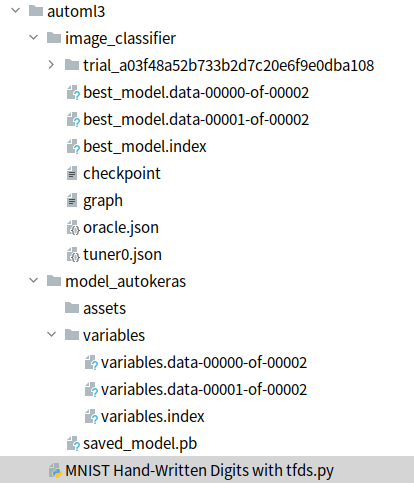